### import Dependecies

In [82]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

### load Dataset

In [25]:
df_emotions = pd.read_csv('/content/Emotions.csv')
df_violance = pd.read_csv('/content/Violance.csv')

In [26]:
df_emotions.head(5)

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4.0
1,1,ive enjoyed being able to slouch about relax a...,0.0
2,2,i gave up my internship with the dmrg and am f...,4.0
3,3,i dont know i feel so lost,0.0
4,4,i am a kindergarten teacher and i am thoroughl...,4.0


In [27]:
df_violance.head(5)

,Tweet_ID,tweet,type
0,ID_0022DWKP,Had a dream i got raped last night. By a guy i...,sexual_violence
1,ID_00395QYM,he thought the word raped means sex and told m...,sexual_violence
2,ID_003EOSSF,She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...,sexual_violence
3,ID_004BBHOD,I was sexually abused for 3 years at age 4 to ...,sexual_violence
4,ID_004F7516,Chessy Prout can do better by telling the trut...,sexual_violence


### Data Preprocessing

In [29]:
# Delete Unwanted Columns

df_emotions.drop(columns=['Unnamed: 0'], inplace = True)
df_violance.drop(columns = ['Tweet_ID'], inplace= True)

In [30]:
print(df_emotions.head(5))
print('='*70)
print(df_violance.head(5))
print('='*70)

                                                text  label
0      i just feel really helpless and heavy hearted    4.0
1  ive enjoyed being able to slouch about relax a...    0.0
2  i gave up my internship with the dmrg and am f...    4.0
3                         i dont know i feel so lost    0.0
4  i am a kindergarten teacher and i am thoroughl...    4.0
                                               tweet             type
0  Had a dream i got raped last night. By a guy i...  sexual_violence
1  he thought the word raped means sex and told m...  sexual_violence
2  She NOT TALKING TO ME I WAS RAPED BY 2 MEN 1 M...  sexual_violence
3  I was sexually abused for 3 years at age 4 to ...  sexual_violence
4  Chessy Prout can do better by telling the trut...  sexual_violence


In [31]:
print(df_emotions.columns)
print(df_violance.columns)

Index(['text', 'label'], dtype='object')
Index(['tweet', 'type'], dtype='object')


In [32]:
# Rename Columns

df_violance.rename(columns={'tweet': 'text', 'type':'label'}, inplace= True)

#### Taking 12k Row Randomly from each dataset

In [33]:
df_emotions['label'].value_counts()

,count
label,
1.0,92472
0.0,79456
3.0,37459
4.0,31136
2.0,22456
5.0,9854


In [34]:
# Will Take 2000 row randomly for each label

emotion_df = pd.DataFrame()

for i in range(6):
  subset = df_emotions[df_emotions['label'] == i].sample(n=2000, random_state=42)
  emotion_df = pd.concat([emotion_df, subset])

In [35]:
emotion_df.shape

(12000, 2)

In [36]:
df_violance['label'].value_counts()

,count
label,
sexual_violence,32648
Physical_violence,5946
emotional_violence,651
economic_violence,217
Harmful_Traditional_practice,188


In [37]:
sexual_violence = df_violance[df_violance['label'] == 'sexual_violence'].sample(n = 4998, random_state=42)
df_violance = df_violance[df_violance['label'] != 'sexual_violence']

In [38]:
violence_df = pd.concat([sexual_violence, df_violance])

In [39]:
violence_df.shape

(12000, 2)

In [44]:
emotion_df.head(3)

,text,label
182376,i love this little boy and sometimes i feel ho...,0.0
93056,i refused to allow anyone to bully me or feel ...,0.0
53408,i feel i can t tell my problems to ridz becaus...,0.0


In [45]:
violence_df.head(3)

,text,label
35209,My cousin was raped by this guy Matthew. She w...,sexual_violence
38191,HAHAHAHAHAHAHHA I DIDN’T SEE IT THE FIRST TIME...,sexual_violence
20925,I remember how I almost got raped like it was ...,sexual_violence


In [47]:
# reset index

emotion_df.reset_index(drop=True, inplace=True)
violence_df.reset_index(drop=True, inplace=True)

### LabelEncoder

In [48]:
from sklearn.preprocessing import LabelEncoder

# Encode labels for the Emotion dataset
emotion_label_encoder = LabelEncoder()
emotion_df['label'] = emotion_label_encoder.fit_transform(emotion_df['label'])

# Encode labels for the Violence dataset
violence_label_encoder = LabelEncoder()
violence_df['label'] = violence_label_encoder.fit_transform(violence_df['label'])


# Verify label ranges for each dataset
print("Emotion labels:", emotion_df['label'].unique())
print("Violence labels:", violence_df['label'].unique())


# Ensure all labels are in range [0, num_classes-1]
assert emotion_df['label'].min() == 0 and emotion_df['label'].max() == len(emotion_label_encoder.classes_) - 1
assert violence_df['label'].min() == 0 and violence_df['label'].max() == len(violence_label_encoder.classes_) - 1

Emotion labels: [0 1 2 3 4 5]
Violence labels: [4 1 3 0 2]


In [49]:
violence_df


,text,label
0,My cousin was raped by this guy Matthew. She w...,4
1,HAHAHAHAHAHAHHA I DIDN’T SEE IT THE FIRST TIME...,4
2,I remember how I almost got raped like it was ...,4
3,He raped me 👈,4
4,"A woman raped by A male: psychological horror,...",4
...,...,...
11995,"Court grants woman’s divorce request, after hu...",1
11996,** My husband beats my mother – Wife tells cou...,1
11997,I was told that me saying Jake was a league av...,1
11998,I’m Leaving My Husband Because He Beats And Ra...,1


In [50]:
# Load StopWords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [51]:
stop_words = set(stopwords.words('english'))

In [52]:
len(stop_words)

179

In [53]:
# make removal stopwords function

def remove_stopwords(text):
  allwords = nltk.word_tokenize(text)
  filtered_words = [word for word in allwords if word.lower() not in stop_words]
  return ' '.join(filtered_words)

In [54]:
emotion_df['text'] = emotion_df['text'].apply(remove_stopwords)
violence_df['text'] = violence_df['text'].apply(remove_stopwords)

### Tokenization && Padding

In [55]:
# Tokenization

tokenizer = Tokenizer()

tokenizer.fit_on_texts(pd.concat([emotion_df['text'], violence_df['text']]))

In [57]:
emotion_sequence = tokenizer.texts_to_sequences(emotion_df['text'])
violence_sequence = tokenizer.texts_to_sequences(violence_df['text'])

In [58]:
emotion_df['text'].iloc[2]

'feel tell problems ridz many occation one blamed back'

In [59]:
emotion_sequence[2:3]

[[1, 54, 1273, 12361, 89, 12362, 15, 1205, 50]]

In [61]:
# Padding
max_len = 50

emotion_pad = pad_sequences(emotion_sequence, maxlen = max_len, padding= 'post')
violence_pad = pad_sequences(violence_sequence, maxlen = max_len, padding= 'post')

In [62]:
emotion_pad[3:4]

array([[   1,  698,  141,   30,    1, 1144,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0]], dtype=int32)

In [63]:
# make labels in numpy array format

emotion_labels = np.array(emotion_df['label'])
violence_labels = np.array(violence_df['label'])

### Model

In [64]:
# separate inputs for each dataset

emotion_input = emotion_pad
violence_input = violence_pad

In [65]:
emotion_input_layer = keras.layers.Input(shape=(max_len,), name='emotion_input')
violence_input_layer = keras.layers.Input(shape=(max_len,), name='violence_input')

In [66]:
# Use Embedding layer

embedding_layers = keras.layers.Embedding(input_dim=len(tokenizer.word_index) +1, output_dim=128)

In [67]:
emotion_embedding = embedding_layers(emotion_input_layer)
violence_embedding = embedding_layers(violence_input_layer)

In [68]:
lstm_layer = keras.layers.LSTM(64, return_sequences=True)

In [69]:
emotion_lstm = lstm_layer(emotion_embedding)
violence_lstm = lstm_layer(violence_embedding)

In [70]:
pooling_layer = keras.layers.GlobalMaxPooling1D()
dropout_layer = keras.layers.Dropout(0.5)

In [71]:
emotion_features =dropout_layer(pooling_layer(emotion_lstm))
violence_features = dropout_layer(pooling_layer(violence_lstm))

In [72]:
(len(emotion_df['label'].unique()), len(violence_df['label'].unique()))

(6, 5)

In [73]:
emotion_output = keras.layers.Dense(6, activation='softmax', name='emotion_output')(emotion_features)
violence_output = keras.layers.Dense(5, activation='softmax', name='violence_output')(violence_features)

In [74]:
model = keras.models.Model(inputs = [emotion_input_layer, violence_input_layer],
                           outputs = [emotion_output, violence_output])

model.compile(optimizer = 'adam',
              loss = {
                  'emotion_output' : 'sparse_categorical_crossentropy',
                  'violence_output' :'sparse_categorical_crossentropy'},
              metrics = {
                  'emotion_output': 'accuracy',
                  'violence_output': 'accuracy',})

In [75]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ emotion_input             │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ violence_input            │ (None, 50)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 128)        │      3,312,768 │ emotion_input[0][0],   │
│                           │                        │                │ violence_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 50, 64)         │         49,408 │ embedding[0][0],       │
│                           │                        │                │ embedding[1][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 64)             │              0 │ lstm[0][0], lstm[1][0] │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64)             │              0 │ global_max_pooling1d[… │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ emotion_output (Dense)    │ (None, 6)              │            390 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ violence_output (Dense)   │ (None, 5)              │            325 │ dropout[1][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,362,891 (12.83 MB)

 Trainable params: 3,362,891 (12.83 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
model.fit(x= {'emotion_input' : emotion_input,
              'violence_input' : violence_input},

          y= {'emotion_output' : emotion_labels,
              'violence_output' : violence_labels,},
          epochs=10,
          batch_size=4
          )

Epoch 1/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 214s 70ms/step - emotion_output_accuracy: 0.4840 - emotion_output_loss: 1.2871 - loss: 1.5709 - violence_output_accuracy: 0.8971 - violence_output_loss: 0.2838
Epoch 2/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 261s 70ms/step - emotion_output_accuracy: 0.9272 - emotion_output_loss: 0.2325 - loss: 0.2549 - violence_output_accuracy: 0.9955 - violence_output_loss: 0.0223
Epoch 3/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 259s 69ms/step - emotion_output_accuracy: 0.9599 - emotion_output_loss: 0.1355 - loss: 0.1492 - violence_output_accuracy: 0.9966 - violence_output_loss: 0.0137
Epoch 4/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 315s 87ms/step - emotion_output_accuracy: 0.9658 - emotion_output_loss: 0.0954 - loss: 0.1020 - violence_output_accuracy: 0.9985 - violence_output_loss: 0.0066
Epoch 5/10
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 283s 94ms/step - emotion_output_accuracy: 0.9802 - emotion_output_loss: 0.0621 - loss: 0.0693 - violence_output_accuracy: 0.9983 - violence_output_los

In [77]:
prediction = model.predict({'emotion_input' : emotion_input,
                            'violence_input' : violence_input})

375/375 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step


In [78]:
prediction

[array([[9.99994695e-01, 4.10270502e-07, 1.53841924e-07, 9.19167860e-07,
         9.18621936e-07, 2.85042051e-06],
        [9.99994099e-01, 6.51768630e-07, 9.06415991e-08, 1.01547710e-06,
         1.94605536e-06, 2.14278521e-06],
        [9.99993384e-01, 1.27837677e-06, 2.38753501e-07, 1.69786097e-06,
         1.40673887e-06, 1.85316946e-06],
        ...,
        [5.10535813e-07, 9.09947531e-08, 2.94770985e-07, 1.09253595e-09,
         1.87616224e-05, 9.99980271e-01],
        [3.99493331e-07, 3.11101260e-08, 2.43087726e-07, 1.17277110e-09,
         7.19002628e-06, 9.99992073e-01],
        [1.22536172e-03, 3.32827796e-04, 2.02134848e-04, 3.56995442e-05,
         1.16350865e-02, 9.86568928e-01]], dtype=float32),
 array([[1.01235482e-08, 1.38490066e-07, 3.87449184e-10, 7.31981009e-09,
         9.99999821e-01],
        [4.06181355e-09, 2.61444431e-08, 2.39485792e-10, 1.73640691e-09,
         9.99999940e-01],
        [7.06503078e-09, 1.37599789e-08, 4.20103924e-10, 8.41398173e-10,
         

In [79]:
emotion_pred = np.argmax(prediction[0], axis=1)
violence_pred = np.argmax(prediction[1], axis=1)

In [93]:
def cm(true, labels, title, pred):
  cm = confusion_matrix(true,pred, normalize= "true")
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.title(title)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.show()

emotion_labels_text = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
violance_lebels_text = ['sexual_violence', 'phiscal_violence', 'emotional_violence', 'Harmful_traditional_practice', 'economic_violence']

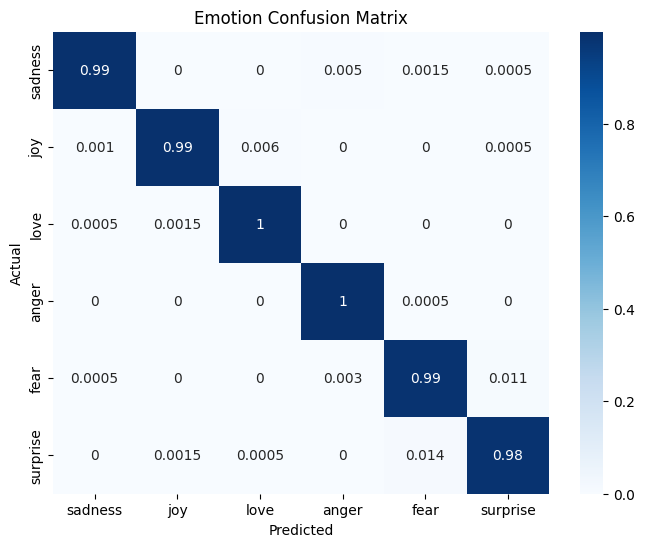

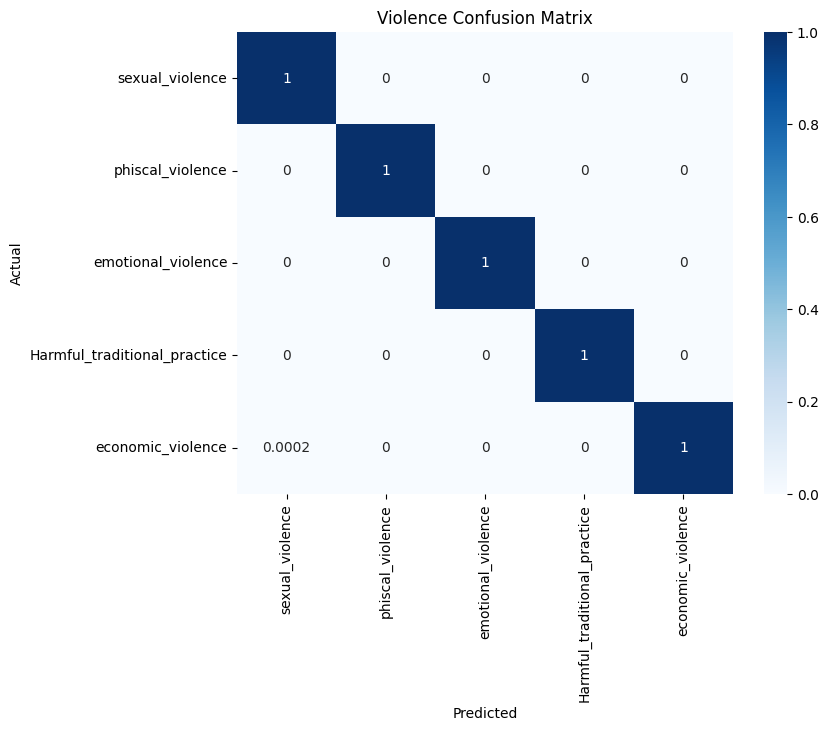

In [94]:
cm(emotion_labels, emotion_labels_text, 'Emotion Confusion Matrix', emotion_pred)
cm(violence_labels, violance_lebels_text, "Violence Confusion Matrix", violence_pred)

#### Manual Testing

In [95]:
def classify_text(input_text):

  input_text_cleaned = remove_stopwords(input_text)
  input_sequence = tokenizer.texts_to_sequences([input_text_cleaned])
  input_padded = pad_sequences(input_sequence, maxlen = 50, padding = 'post')


  predictions = model.predict({'emotion_input' : input_padded,
                            'violence_input' : input_padded})
  emotion_pred = np.argmax(predictions[0], axis = 1)[0]
  violence_pred = np.argmax(predictions[1], axis = 1)[0]


  major_labels = ['Emotion', 'Violence']
  major_label_index = np.argmax([np.max(predictions[0]), np.max(predictions[1])])
  major_label = major_labels[major_label_index]

  emotion_labels_text = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
  violence_labels_text = ['sexual_violence', 'physical_violence', 'emotional_violence', 'Harmful_traditional_practice', 'economic violence']
  hate_labels_text = ['offensive speech', 'Neither', 'Hate Speech']

  if major_label == 'Emotion':
    sub_label = emotion_labels_text[emotion_pred]
  else:
    sub_label = violence_labels_text[violence_pred]


  return major_label, sub_label

In [96]:
import ipywidgets as widgets
from IPython.display import display

In [97]:
input_text_widget = widgets.Text(
    description = 'Input text : ',
    placeholder = 'Enter you text'
)

In [98]:
button = widgets.Button(description = 'classify')

In [99]:
output = widgets.Output()

In [100]:
def on_button_click(b):
  with output:
    output.clear_output()
    input_text = input_text_widget.value
    major_label, sub_label = classify_text(input_text)
    print(f'Major Label : {major_label}')
    print(f'Sub Label : {sub_label}')

button.on_click(on_button_click)

In [101]:
display(input_text_widget, button, output)

Text(value='', description='Input text : ', placeholder='Enter you text')

Button(description='classify', style=ButtonStyle())

Output()